In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!pip install timm
!pip install torch torchvision pillow
!pip install matplotlib scikit-learn

In [8]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, cohen_kappa_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
data_path = '/content/drive/MyDrive/UCMerced_LandUse/UCMerced_LandUse/Images_converted'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [10]:
dataset = ImageFolder(root=data_path, transform=transform)
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)
num_classes = len(dataset.classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [11]:
model_seresnext50 = timm.create_model('seresnext50_32x4d', pretrained=True)
model_seresnext50.fc = nn.Linear(model_seresnext50.fc.in_features, num_classes)
model_seresnext50 = model_seresnext50.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_seresnext50.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [13]:
epochs = 25
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    model_seresnext50.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_seresnext50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)
    scheduler.step()

    model_seresnext50.eval()
    val_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_seresnext50(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    val_losses.append(val_loss / len(valid_loader))
    val_accuracies.append(100 * correct / total)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%")


Epoch 1/25, Train Loss: 0.9317, Train Acc: 74.94%, Val Loss: 0.3264, Val Acc: 90.24%
Epoch 2/25, Train Loss: 0.3267, Train Acc: 90.60%, Val Loss: 0.2222, Val Acc: 93.33%
Epoch 3/25, Train Loss: 0.2055, Train Acc: 94.11%, Val Loss: 0.1460, Val Acc: 96.43%
Epoch 4/25, Train Loss: 0.1171, Train Acc: 97.14%, Val Loss: 0.1604, Val Acc: 95.95%
Epoch 5/25, Train Loss: 0.0536, Train Acc: 98.69%, Val Loss: 0.0558, Val Acc: 98.33%
Epoch 6/25, Train Loss: 0.1134, Train Acc: 97.08%, Val Loss: 0.1341, Val Acc: 95.24%
Epoch 7/25, Train Loss: 0.0640, Train Acc: 98.27%, Val Loss: 0.1751, Val Acc: 95.00%
Epoch 8/25, Train Loss: 0.0967, Train Acc: 97.50%, Val Loss: 0.0813, Val Acc: 97.38%
Epoch 9/25, Train Loss: 0.1247, Train Acc: 96.96%, Val Loss: 0.2733, Val Acc: 93.10%
Epoch 10/25, Train Loss: 0.0892, Train Acc: 97.74%, Val Loss: 0.2476, Val Acc: 95.48%
Epoch 11/25, Train Loss: 0.0304, Train Acc: 99.35%, Val Loss: 0.0781, Val Acc: 97.38%
Epoch 12/25, Train Loss: 0.0138, Train Acc: 99.76%, Val Loss: 0

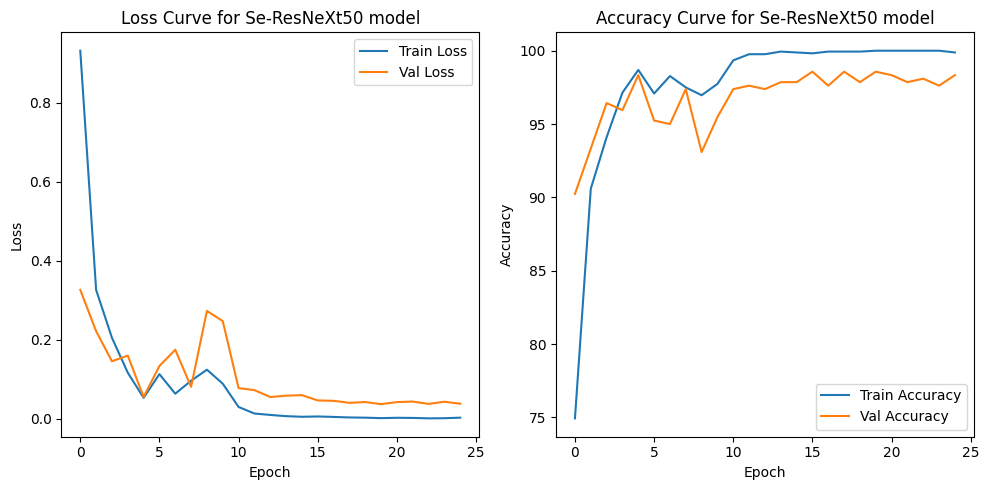

In [15]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve for Se-ResNeXt50 model')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve for Se-ResNeXt50 model')

plt.tight_layout()
plt.show()

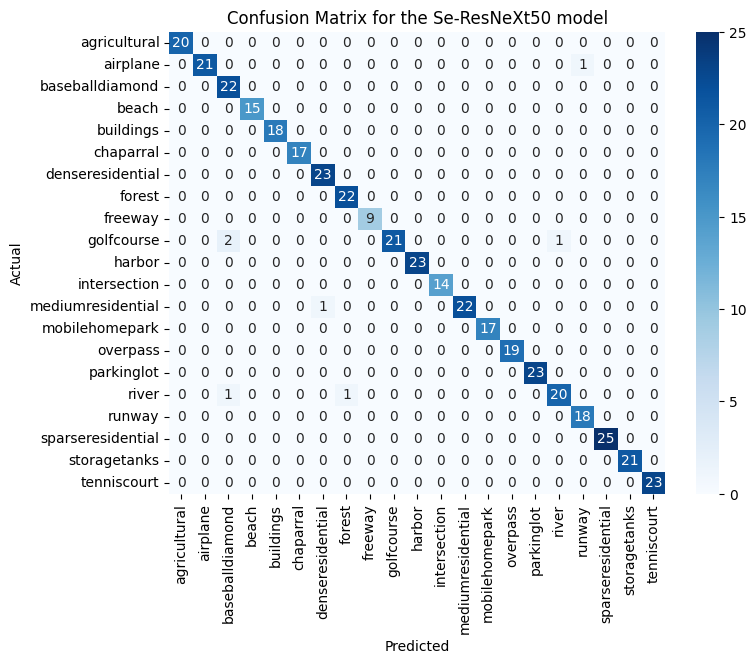

In [16]:
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for the Se-ResNeXt50 model')
plt.show()


In [17]:
kappa = cohen_kappa_score(all_labels, all_preds)
oa = accuracy_score(all_labels, all_preds)
print(f"Kappa: {kappa:.4f}")
print(f"Overall Accuracy: {oa:.4f}")
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=dataset.classes))

Kappa: 0.9825
Overall Accuracy: 0.9833
Classification Report:
                   precision    recall  f1-score   support

     agricultural       1.00      1.00      1.00        20
         airplane       1.00      0.95      0.98        22
  baseballdiamond       0.88      1.00      0.94        22
            beach       1.00      1.00      1.00        15
        buildings       1.00      1.00      1.00        18
        chaparral       1.00      1.00      1.00        17
 denseresidential       0.96      1.00      0.98        23
           forest       0.96      1.00      0.98        22
          freeway       1.00      1.00      1.00         9
       golfcourse       1.00      0.88      0.93        24
           harbor       1.00      1.00      1.00        23
     intersection       1.00      1.00      1.00        14
mediumresidential       1.00      0.96      0.98        23
   mobilehomepark       1.00      1.00      1.00        17
         overpass       1.00      1.00      1.00    

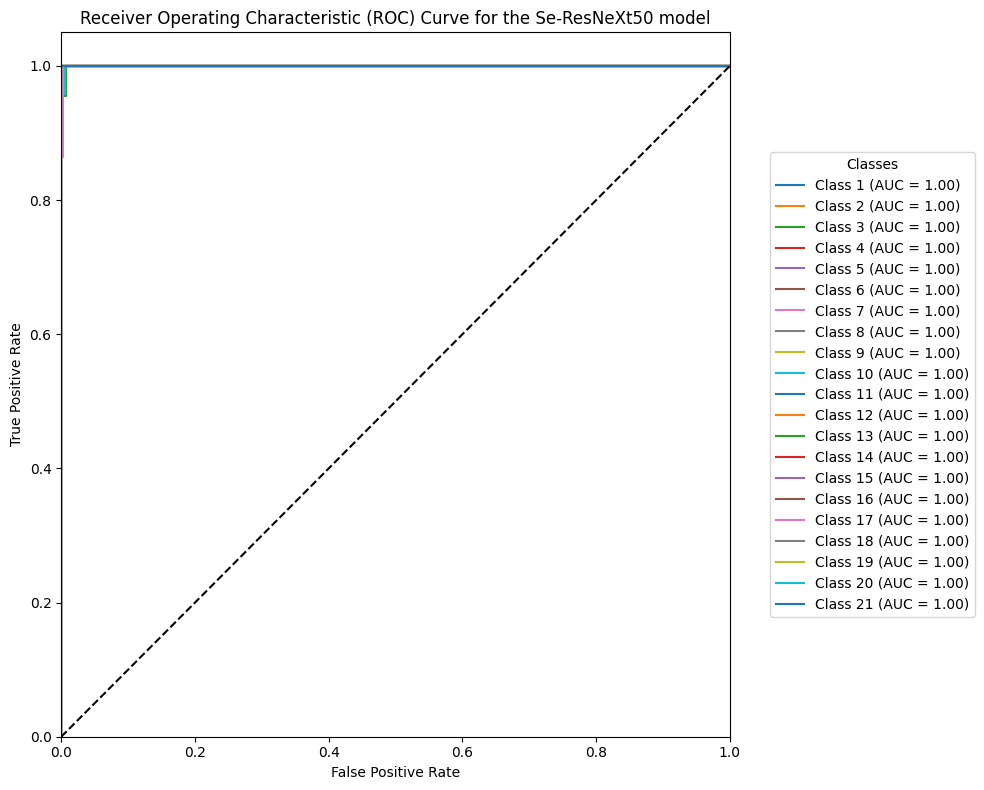

In [21]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
y_true_bin = label_binarize(all_labels, classes=np.arange(num_classes))
all_preds = []
with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_seresnext50(inputs)
        all_preds.extend(torch.softmax(outputs, dim=1).cpu().numpy())
fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], np.array([pred[i] for pred in all_preds]))
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i+1} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for the Se-ResNeXt50 model')
plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5), title="Classes")

plt.tight_layout()
plt.show()
